# Model Fine-Tuning Experimentation

This notebook is used to experiment with different hyperparameters for the FAMD and HDBSCAN models. 
The goal is to find a configuration that maximizes the DBCV score while keeping the noise ratio reasonable.

In [2]:
import itertools
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from hdbscan.validity import validity_index
from sklearn.metrics import silhouette_score

# Add the service root directory to sys.path to allow importing from src
# Assuming notebook is in services/model_training/src/notebooks
sys.path.append(os.path.abspath(os.path.join("..", "..")))

from src import cluster, config, data, preprocess

In [3]:
# 1. Load Data
try:
    df_original = data.load_and_prepare_data()
    print(f"Successfully loaded data. Shape: {df_original.shape}")
except Exception as e:
    print(f"Error loading data: {e}")
    # Create dummy data if file not found (for testing the notebook logic without ETL run)
    print("Creating dummy data for testing...")
    df_original = pd.DataFrame(
        {
            "store_id": [f"s{i}" for i in range(100)],
            "regional": np.random.choice(["R1", "R2"], 100),
            "placement": np.random.choice(["Mall", "Street"], 100),
            "anos_de_loja": np.random.uniform(1, 10, 100),
            "size_m2": np.random.uniform(50, 500, 100),
            "total_revenue": np.random.uniform(10000, 100000, 100),
            "avg_ticket_item": np.random.uniform(20, 100, 100),
            "revenue_per_sqm": np.random.uniform(100, 1000, 100),
            "avg_inventory_depth": np.random.uniform(100, 500, 100),
            "unique_products_stocked": np.random.randint(50, 200, 100),
            "opening_date": pd.date_range(start="2020-01-01", periods=100),
        }
    ).set_index("store_id")

Successfully loaded data. Shape: (100, 23)


In [4]:
# 2. Define Hyperparameter Grid
famd_components_grid = [3, 4, 5]
min_cluster_size_grid = [5, 10, 15]
min_samples_grid = [1, 3, 5]

results = []

print(
    f"Starting Grid Search over {len(famd_components_grid) * len(min_cluster_size_grid) * len(min_samples_grid)} combinations..."
)

Starting Grid Search over 27 combinations...


In [6]:
# 3. Run Experimentation Loop
for n_components in famd_components_grid:
    # Monkeypatch config for FAMD
    config.FAMD_COMPONENTS = n_components

    # Run Preprocessing (FAMD) once per n_components to save time
    print(f"\n--- Preprocessing with FAMD n_components={n_components} ---")
    try:
        df_context, df_behavioral = preprocess.select_and_transform_features(
            df_original
        )
        # Capture the famd_model to get explained inertia
        X_final, famd_model, _ = preprocess.run_preprocessing(df_context, df_behavioral)
        famd_explained_inertia = famd_model.percentage_of_variance_.sum()
        print(f"FAMD Explained Inertia: {famd_explained_inertia:.2f}%")

    except Exception as e:
        print(f"Preprocessing failed for n={n_components}: {e}")
        continue

    for min_cluster_size, min_samples in itertools.product(
        min_cluster_size_grid, min_samples_grid
    ):
        # Monkeypatch config for HDBSCAN
        config.HDBSCAN_PARAMS["min_cluster_size"] = min_cluster_size
        config.HDBSCAN_PARAMS["min_samples"] = min_samples

        try:
            # Run Clustering
            df_clustered, hdbscan_model, _ = cluster.run_clustering(
                X_final, df_original
            )

            # --- Calculate Metrics ---\
            initial_labels = df_clustered["cluster"]
            final_labels = df_clustered["cluster_final"]
            n_clusters = final_labels.nunique()

            dbcv_score = validity_index(
                X_final, initial_labels.values, metric=config.HDBSCAN_TEST_METRIC
            )

            if n_clusters > 1:
                sil_score = silhouette_score(X_final, final_labels)
            else:
                sil_score = -1.0

            noise_ratio = (initial_labels == -1).sum() / len(df_clustered)

            results.append(
                {
                    "famd_n": n_components,
                    "famd_explained_inertia": famd_explained_inertia,
                    "min_cluster_size": min_cluster_size,
                    "min_samples": min_samples,
                    "n_clusters_final": n_clusters,
                    "dbcv_score": dbcv_score,
                    "silhouette_score": sil_score,
                    "noise_ratio": noise_ratio,
                }
            )

        except ValueError as e:
            if "Found array with 0 sample(s)" in str(
                e
            ) and "RandomForestClassifier" in str(e):
                results.append(
                    {
                        "famd_n": n_components,
                        "famd_explained_inertia": famd_explained_inertia,
                        "min_cluster_size": min_cluster_size,
                        "min_samples": min_samples,
                        "n_clusters_final": 0,  # 0 Clusters found
                        "dbcv_score": -1.0,  # Minimum Score
                        "silhouette_score": -1.0,  # Minimum Score
                        "noise_ratio": 1.0,  # 100% Noise
                    }
                )
            else:
                print(
                    f"  -> Failed for combo ({n_components}, {min_cluster_size}, {min_samples}): {e}"
                )

        except Exception as e:
            print(
                f"  -> Failed for combo ({n_components}, {min_cluster_size}, {min_samples}): {e}"
            )


--- Preprocessing with FAMD n_components=3 ---
FAMD Explained Inertia: 48.86%

--- Preprocessing with FAMD n_components=4 ---
FAMD Explained Inertia: 60.47%

--- Preprocessing with FAMD n_components=5 ---
FAMD Explained Inertia: 71.48%


In [7]:
# 4. Analyze Results
results_df = pd.DataFrame(results)
# Sort by our primary metric, DBCV, in descending order
results_df = results_df.sort_values(by="dbcv_score", ascending=False).reset_index(
    drop=True
)

print("Top 10 Configurations by DBCV Score:")
display(results_df.head(10))

Top 10 Configurations by DBCV Score:


,famd_n,famd_explained_inertia,min_cluster_size,min_samples,n_clusters_final,dbcv_score,silhouette_score,noise_ratio
0,3,48.86489,5,3,2,0.275808,0.304462,0.19
1,3,48.86489,10,3,2,0.275808,0.304462,0.19
2,3,48.86489,10,3,2,0.275808,0.304462,0.19
3,3,48.86489,5,3,2,0.275808,0.304462,0.19
4,3,48.86489,5,5,2,0.261429,0.304462,0.24
5,3,48.86489,5,5,2,0.261429,0.304462,0.24
6,4,60.46879,5,5,2,0.227849,0.289833,0.28
7,4,60.46879,5,5,2,0.227849,0.289833,0.28
8,3,48.86489,5,1,2,0.163515,0.310225,0.07
9,3,48.86489,10,1,2,0.163515,0.310225,0.07


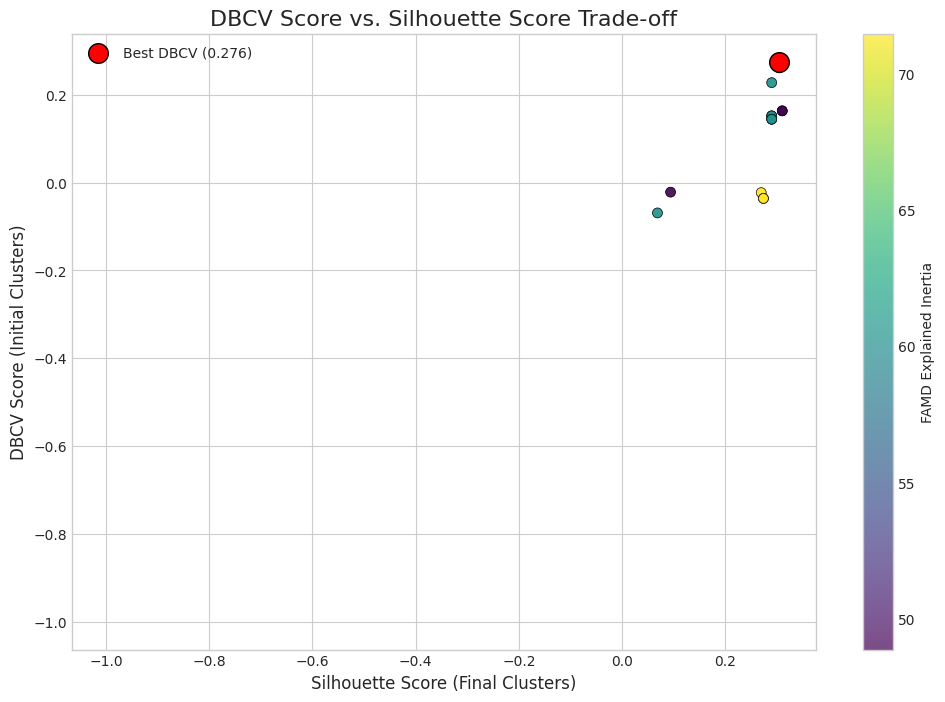

In [8]:
# 5. Visualization: DBCV vs. Silhouette
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(
    results_df["silhouette_score"],
    results_df["dbcv_score"],
    c=results_df["famd_explained_inertia"],
    s=results_df["n_clusters_final"] * 25,  # Size by number of clusters
    cmap="viridis",
    alpha=0.7,
    edgecolors="k",
    linewidth=0.5,
)

# Add a colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("FAMD Explained Inertia")

# Add labels and title
ax.set_title("DBCV Score vs. Silhouette Score Trade-off", fontsize=16)
ax.set_xlabel("Silhouette Score (Final Clusters)", fontsize=12)
ax.set_ylabel("DBCV Score (Initial Clusters)", fontsize=12)

# Highlight the best point
best_idx = results_df["dbcv_score"].idxmax()
best_point = results_df.loc[best_idx]
ax.scatter(
    best_point["silhouette_score"],
    best_point["dbcv_score"],
    color="red",
    s=200,
    edgecolor="black",
    zorder=5,
    label=f"Best DBCV ({best_point.dbcv_score:.3f})",
)
ax.legend()

plt.show()